(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic
# import tools to benchmark
import BenchmarkTools

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import optimization libraries
import Zygote
import JuMP
import NLopt
import Ipopt

# Import library to perform tensor operations
using TensorOperations: @tensor

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Approximating geodesics with cubic splines

In this notebook we will explore approximating the solution to the geodesic
equation boundary condition using non-linear optimization via `JuMP.jl`.

## Simple 3D example

As a toy model to work through to gain intuition, let us define a function of
the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = 10 * exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's evaluate the Riemmanian metric of this function over a grid of values. For
this, we will use the `diffgeo` module from our package.

In [3]:
# Define latent space domain
range = 3

# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-range * 1.1, range * 1.1, n_range)

manifold_metric = sqrt.(
    LinearAlgebra.det.(
        [
            Antibiotic.diffgeo.riemmanian_metric(f̲, collect(x)) 
            for x in Iterators.product(z1, z2)
        ]
    )
);

Now, let's plot this quantity both on the input and output space to gain
intuition to what it represents.

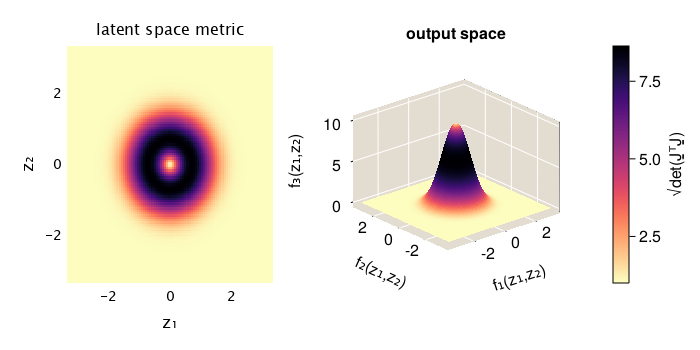

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for latent space
ax1 = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric",
)

# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add axis for latent space
ax2 = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate function on grid
f_output = hcat(vec([f̲(collect(x)) for x in Iterators.product(z1, z2)])...)

# Plot surface
surface!(
    ax2, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

# Separate axis
colgap!(gl, 50)

fig

We can see that indeed the Riemmanian metric task high values when the local map
(intrinsic geometry) is highly distorted with respect to the extrinsic geometry.

## Approximating geodesics with discretized curves

The numerical solution of boundary-value problems can be extremely tricky and
unstable when numerically solving the geodesic differential equation. Therefore,
we will approximate the energy function over a parametric curve
$\underline{\gamma}(t)$ with a set of points $\{\underline{\gamma}_k
\}_{k=1}^N$. The energy functional
$$
E[\underline{\gamma}(t)] = \int_0^1 dt\; \left\langle
    \underline{\dot{\gamma}}(t), 
    \underline{\underline{M}}\; \underline{\dot{\gamma}}(t)
\right\rangle,
$$
is then approximated with a function $\tilde{E}$ of the form
$$
\tilde{E}(\{\underline{\gamma}_k \}) =
\sum_{k = 2}^N
\left\langle
    \frac{\Delta \underline{\gamma}_k}{\Delta t}, 
    \underline{\underline{M_k}}
    \frac{\Delta \underline{\gamma}_k}{\Delta t}
\right\rangle \Delta t,
$$
where $\Delta t = \frac{1}{N}$ since the integration interval is from zero to 
one, $\underline{\underline{M_k}}$ is the Riemmanian metric evaluated at 
$\underline{\gamma}_k$, $\langle\cdot, \cdot\rangle$ is the inner product, and
$$
\Delta \underline{\gamma}_k = \underline{\gamma}_k - \underline{\gamma}_{k-1},
$$
such that
$$
\frac{\Delta \underline{\gamma}_k}{\Delta t} \approx 
\underline{\dot{\gamma}}(t),
$$
evaluated at $\underline{\gamma}_k$


Let's define a function to compute the energy of a discretized curve
$\{\underline{\gamma}_k\}$ on the manifold.

In [5]:
@doc raw"""
    curve_energy(Δγ̲, manifold, γ̲ₒ)

Function to compute the (discretized) integral defining the energy of a curve γ
on a Riemmanina manifold. The energy is defined as

    E = ∫ dt ⟨γ̲̇(t), M̲̲ γ̲̇(t)⟩,

where γ̲̇(t) defines the velocity of the parametric curve, and M̲̲ is the
Riemmanian metric. For this function, we use finite differences from the curve
sample points `γ` to compute this integral.

# Arguments
- `Δγ̲::AbstractVector{T}`: `d×N` long vector where `d` is the dimension of the
  manifold on which the curve lies and `N` is the number of points along the
  curve (without the initial point `γ̲ₒ`). This vector represents the differences
  between two contiguous points γ̲ₖ and `γ̲ₖ₊₁`. The longer the number of entries
  in this vector, the more accurate the energy estimate will be. NOTE: Notice
  that this function asks 
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
"""
function curve_energy(
    Δγ̲::AbstractMatrix{T}, manifold::Function, γ̲ₒ::AbstractVector{T}
) where T <: Real
    # Define Δt
    Δt = 1 / (length(Δγ̲) ÷ length(γ̲ₒ))

    # Reshape Δγ̲ to a matrix with each row as a dimension
    Δγ̲̲ = reshape(Δγ̲, (length(γ̲ₒ), (length(Δγ̲) ÷ length(γ̲ₒ))))

    # Reconstruct point values from initial point and Δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(Δγ̲̲, dims=2)

    # Evaluate and return energy
    return (1/2) * sum(
        [
            LinearAlgebra.dot(
                Δγ̲̲[:, i], 
                Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, i]), 
                Δγ̲̲[:, i]
            ) * Δt 
            for i = 1:size(Δγ̲̲, 2)
        ]
    ) 
end # function

curve_energy

To minimize the energy, we need to define the gradient in the format required by
`JuMP.jl`.

In [6]:
function ∇curve_energy!(
    ∇E::AbstractVector{T}, 
    δγ̲::AbstractVector{T}, 
    manifold::Function, 
    γ̲ₒ::AbstractVector{T},
    out_dim::Int,
) where T <: AbstractFloat
    # Reshape δγ̲ to a matrix with each row as a dimension
    δγ̲̲ = reshape(δγ̲, length(γ̲ₒ), :)

    # Reconstruct point values from initial point and δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(δγ̲̲, dims=2)

    # Initialize array where to save the metric evaluated at each point
    M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 2)..., size(δγ̲̲, 2))

    # Initialize array where to save the derivative of the metric evaluated at
    # each point.
    ∂M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 3)..., size(δγ̲̲, 2))

    # Loop through each γ value
    for k = 1:size(δγ̲̲, 2)
        # Compute metric
        M̲̲[:, :, k] .= Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, k])
        # Compute derivative of metric
        ∂M̲̲[:, :, :, k] .= Antibiotic.diffgeo.∂M̲̲∂γ̲(manifold, γ̲̲[:, k], out_dim)
    end # for

    # Define Δt
    Δt = 1 / (size(γ̲̲, 2) - 1)

    # Initialize array to save gradient. Note: The gradient is obviously a
    # vector, but we will store it as an array to keep track of which point
    # along the curve each entry corresponds to
    ∇E_mat = zeros(T, size(δγ̲̲)...)
    
    # Loop through each of the entries
    for k = 1:size(γ̲̲, 2)-1
        # Extract relevant pieces
        _M̲̲ = @view M̲̲[:, :, k]
        _∂M̲̲ = @view ∂M̲̲[:, :, :, k]
        _δγ̲ = @view δγ̲̲[:, k]

        # Compute gradient
        @tensor ∇E_mat[:, k][l] = Δt / 2 * (
            _∂M̲̲[i, j, l] * _δγ̲[i] * _δγ̲[j] +
            2 * _M̲̲[l, i] * _δγ̲[i]
        )
    end # for
    # Update gradient vector in place
    ∇E .= ∇E_mat[:]
end # function

∇curve_energy! (generic function with 1 method)

Let's define a function to initialize the values of a line in latent space
connected at the desired initial and final points.

In [7]:
function curve_init(
    γ_init::Vector{T}, γ_end::Vector{T}, n_points::Int
) where T <: AbstractFloat
    # Initialize array where to return curve
    γ = Matrix{T}(undef, length(γ_init), n_points)
    # Set initial and final points
    γ[:, 1] = γ_init
    γ[:, end] = γ_end

    # Loop through dimensions
    for d = 1:length(γ_init)
        # Interpolate between points
        γ[d, 2:end-1] = LinRange(γ_init[d], γ_end[d], n_points-2)
    end # for

    return diff(γ, dims=2)[:]
end # function

curve_init (generic function with 1 method)

With this initialization function, let's test both of our functions.

In [23]:
# Define points to connect
γ_init = [2.0, -2.0]
γ_end = [-2.0, 1.0]

# Define number of points
n_points = 25

# Initialize curve
δγ̲ₒ = curve_init(γ_init, γ_end, n_points);

First we test the energy.

In [24]:
curve_energy(δγ̲ₒ, f̲, γ_init)

0.4545731135561752

Let's benchmark this function.

In [25]:
BenchmarkTools.@benchmark curve_energy(δγ̲ₒ, f̲, γ_init)

BenchmarkTools.Trial: 9086 samples with 1 evaluation.
 Range (min … max):  510.917 μs …  27.008 ms  ┊ GC (min … max): 0.00% … 97.46%
 Time  (median):     528.458 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   548.949 μs ± 602.100 μs  ┊ GC (mean ± σ):  2.56% ±  2.28%

    ▂▃██▇▅▄▃▂▁                                                   
  ▁▄███████████▇▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  511 μs           Histogram: frequency by time          631 μs <

 Memory estimate: 167.92 KiB, allocs estimate: 4934.

Next, we test the gradient.

In [26]:
# Initialize vector where to save gradient
∇E = similar(δγ̲ₒ)

# Compute gradient
∇curve_energy!(∇E, δγ̲ₒ, f̲, γ_init, 3)

48-element Vector{Float64}:
  0.0
  0.0
 -0.007954644531035998
  0.005980255475637694
 -0.008263990518485666
  0.00631387399396675
 -0.009964835118470983
  0.008229803662344251
 -0.017201651708303962
  0.016857371963268534
  ⋮
  0.019787008680223733
 -0.013786645637575692
  0.009171332127852969
 -0.008777130513783265
  0.006460999385432911
 -0.007976916884999968
  0.0059826876637499755
  0.0
  0.0

The function seems to be working as well. Let's also benchmark this function.

In [27]:
BenchmarkTools.@benchmark ∇curve_energy!(∇E, δγ̲ₒ, f̲, γ_init, 3)

BenchmarkTools.Trial: 2764 samples with 1 evaluation.
 Range (min … max):  1.654 ms … 28.226 ms  ┊ GC (min … max): 0.00% … 92.81%
 Time  (median):     1.722 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.807 ms ±  1.392 ms  ┊ GC (mean ± σ):  4.10% ±  4.98%

     ▁▂▄▄▄▄▆█▇▇█▆▄▃▂▃                                         
  ▃▅██████████████████▆▅▄▅▅▄▄▄▅▃▃▃▃▄▃▃▂▃▃▃▂▃▂▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂ ▄
  1.65 ms        Histogram: frequency by time        1.96 ms <

 Memory estimate: 916.17 KiB, allocs estimate: 16988.

Let's register our functions to be used with Jump. The arguments to register
are:

1. The model for which the functions are registered.
2. A Julia symbol object which serves as the name of the user-defined function
   in JuMP expressions.
3. The number of input arguments that the function takes.
4. The Julia method which computes the function
5. A flag to instruct JuMP to compute exact gradients automatically.

In [28]:
# Define function with fixed manifold
Energy(δγ̲::T...) where T <: AbstractFloat = curve_energy(collect(δγ̲), f̲, γ_init)
∂̲Energy!(
    ∇E::AbstractVector{T}, δγ̲::T...
) where T <: AbstractFloat = ∇curve_energy!(
    ∇E, collect(δγ̲), f̲, γ_init, 3
)

# Initialize a JuMP model
# model = JuMP.Model(Ipopt.Optimizer)


# Initialize a JuMP model
model = JuMP.Model(NLopt.Optimizer)
# Set algorithm for optimizer
# JuMP.set_optimizer_attribute(model, "algorithm", :AUGLAG)
# JuMP.set_optimizer_attribute(model, "local_optimizer", :LD_LBFGS)
JuMP.set_optimizer_attribute(model, "algorithm", :LD_SLSQP)

model

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: NLopt

Let's register the model

In [29]:
# Register model
JuMP.register(model, :energy, length(δγ̲ₒ), Energy, ∂̲Energy!; autodiff=false)

Next, we define the variables for our optimization.

In [30]:
# Register variables
JuMP.@variable(model, δγ[1:length(δγ̲ₒ)])

48-element Vector{JuMP.VariableRef}:
 δγ[1]
 δγ[2]
 δγ[3]
 δγ[4]
 δγ[5]
 δγ[6]
 δγ[7]
 δγ[8]
 δγ[9]
 δγ[10]
 ⋮
 δγ[40]
 δγ[41]
 δγ[42]
 δγ[43]
 δγ[44]
 δγ[45]
 δγ[46]
 δγ[47]
 δγ[48]

As well as the constraints on each dimension.

In [31]:
# Define dimensionality of latent space
d = length(γ_init)

# Set constraints for each dimension
# JuMP.@NLconstraint(model, c[i=1:d], sum(δγ[i:d:end]) == (γ_end .- γ_init)[i])

JuMP.@NLconstraint(
    model, 
    c[i=1:d], 
    sum(δγ[j] for j = i:d:length(δγ̲ₒ)) == (γ_end .- γ_init)[i]
)

2-element Vector{JuMP.NonlinearConstraintRef{JuMP.ScalarShape}}:
 (δγ[1] + δγ[3] + δγ[5] + δγ[7] + δγ[9] + δγ[11] + δγ[13] + δγ[15] + δγ[17] + δγ[19] + δγ[21] + δγ[23] + δγ[25] + δγ[27] + δγ[29] + δγ[31] + δγ[33] + δγ[35] + δγ[37] + δγ[39] + δγ[41] + δγ[43] + δγ[45] + δγ[47]) - -4.0 = 0
 (δγ[2] + δγ[4] + δγ[6] + δγ[8] + δγ[10] + δγ[12] + δγ[14] + δγ[16] + δγ[18] + δγ[20] + δγ[22] + δγ[24] + δγ[26] + δγ[28] + δγ[30] + δγ[32] + δγ[34] + δγ[36] + δγ[38] + δγ[40] + δγ[42] + δγ[44] + δγ[46] + δγ[48]) - 3.0 = 0

Let's set the initial values for the optimization.

In [32]:
# Loop through variables
for (i, δ) in enumerate(δγ̲ₒ)
    JuMP.set_start_value(δγ[i], δ)
end # for

Finally, we set the objective of minimizing the energy function.

In [33]:
# Set objective
JuMP.@NLobjective(model, Min, energy(δγ...))

In [34]:
JuMP.optimize!(model)

In [35]:
JuMP.solution_summary(model)

* Solver : NLopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "FTOL_REACHED"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 7.26829e-02
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 8.15829e-01


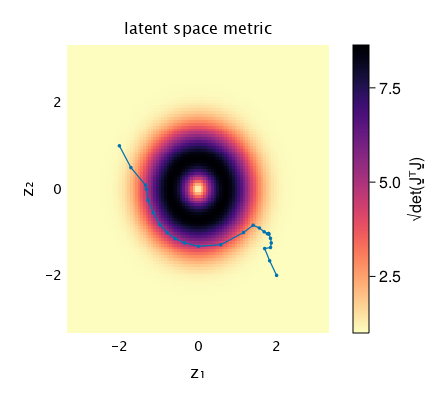

In [36]:
# Construct solution from differences
γ = hcat(γ_init, γ_init .+  cumsum(reshape(JuMP.value.(δγ), 2, :), dims=2))

# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add initial guess
scatterlines!(ax_input, eachrow(γ)..., markersize=5)
# Add optimized curve
# scatterlines!(ax_input, eachrow(γ_opt)..., markersize=5, color=:red)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig